In [30]:
pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.


In [31]:
# the bare minimum
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.colors import ListedColormap
import numpy as np

# more advanced
from lonboard._map import Map
from lonboard._layer import PolygonLayer  # for mapping in 3D
from lonboard.colormap import (
    apply_categorical_cmap,
    apply_continuous_cmap,
)  # for assigning colors
from palettable.colorbrewer.sequential import PuRd_9  # for color palettes
from matplotlib.colors import LogNorm  # for logarithmic normalization
import pygwalker as pyg  # for creating interactive data visualizations

In [ ]:
# I'm going to load and look at the Transportation Structures in NYC Data Set
transport = gpd.read_file(
    "/Users/alinetheo/Documents/Columbia/Summer 2025/Mapping Systems/Data Sets/NYC Planimetric Database_ Transportation Structures_20250711/geo_export_26a8cb53-5eaf-4f1b-b83c-2b268fc092a6.shp"
)

In [33]:
transport.head()

,source_id,sub_code,feat_code,name,status,shape_leng,shape_area,geometry
0,1.323000e+10,230000.0,2300.0,NO NAME,Updated,32349.778891,1.269776e+06,"POLYGON ((-73.88735 40.82205, -73.88738 40.822..."
1,1.423300e+10,233000.0,2330.0,NO NAME,Unchanged,106.016474,2.185770e+02,"POLYGON ((-73.92427 40.82721, -73.92428 40.827..."
2,0.000000e+00,230000.0,2300.0,None,New,708.530999,8.596574e+03,"POLYGON ((-73.90866 40.72745, -73.9085 40.7273..."
3,1.323300e+10,233000.0,2330.0,NO NAME,Unchanged,539.036395,2.100705e+03,"POLYGON ((-73.9387 40.78659, -73.93896 40.7863..."
4,1.223100e+10,231000.0,2310.0,NO NAME,Unchanged,82.542414,3.307481e+01,"POLYGON ((-73.97669 40.75432, -73.9767 40.7543..."


In [34]:
transport.columns

Index(['source_id', 'sub_code', 'feat_code', 'name', 'status', 'shape_leng',
       'shape_area', 'geometry'],
      dtype='object')

In [9]:
transport.status.value_counts()

status
Unchanged    2086
Updated        96
New            65
Name: count, dtype: int64

In [ ]:
# I want to focus on the status of the transportation structures
transport_status_codes = {
    "01": "Unchanged",
    "02": "Updated",
    "03": "New",
}

In [12]:
transport["status"] = transport.status.map(transport_status_codes)

Box(children=(HTML(value='\n<div id="ifr-pyg-000639aa51e2f4c0RxH5dTIZks2o3c0J" style="height: auto">\n    <hea…

Text(0.5, 1.0, 'NYC Transportation Structures Map')

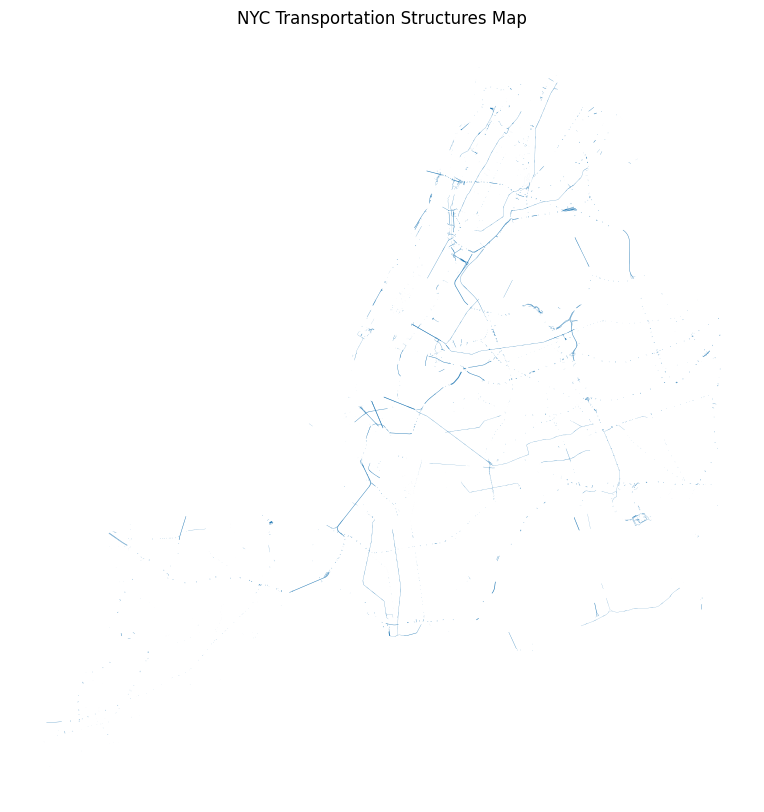

In [19]:
transport_non_spatial = transport.drop(columns=["geometry"])

# Invoke pygwalker, begin exploring the data interactively
pyg.walk(transport_non_spatial)

transport.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC Transportation Structures Map")

In [27]:
transport.fillna({"status": "Unknown"}, inplace=True)

In [35]:
transport.status.unique()

array(['Updated', 'Unchanged', 'New'], dtype=object)

In [36]:
cmap = {
    "Updated": "#f0bd04",
    "Unchanged": "#ff0000",
    "New": "#219F21",
}

In [38]:
transport["color"].unique()

array(['#f0bd04', '#ff0000', '#219F21'], dtype=object)

In [37]:
transport["color"] = transport["status"].map(cmap)

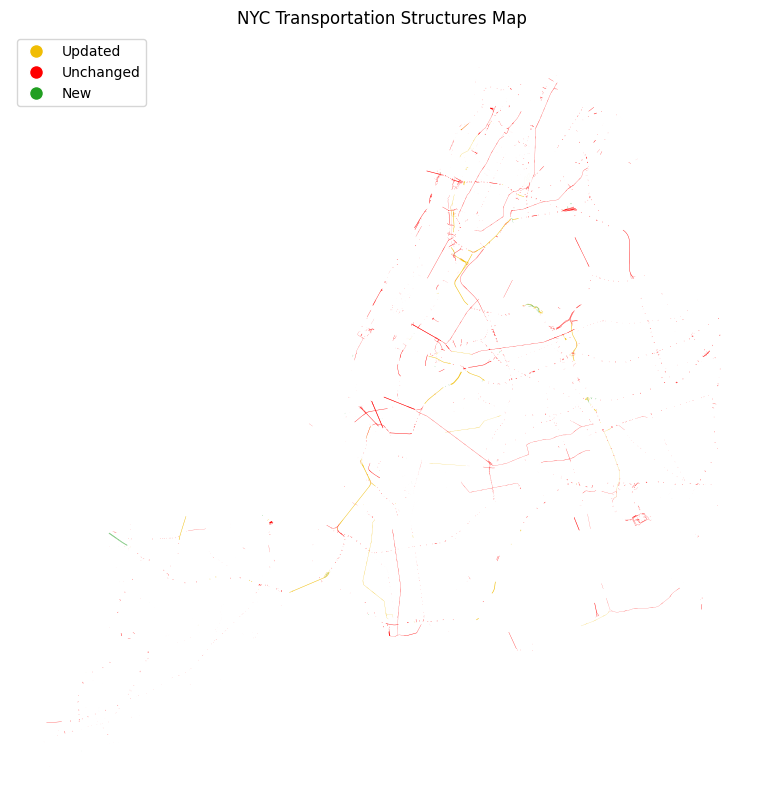

In [39]:
ax = transport.plot(
    color=transport["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC Transportation Structures Map")


# populate legend items based on dict from above
legend_colors = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

In [ ]:
# I want to overlay the transportation information on top of a map of NYC boundaries to give context

boundaries = gpd.read_file(
    "/Users/alinetheo/Documents/Columbia/Summer 2025/Mapping Systems/Data Sets/nybb_25b 2/nybb.shp"
)

In [56]:
print("Boundaries CRS:", boundaries.crs)
print("Transport CRS:", transport.crs)

Boundaries CRS: EPSG:2263
Transport CRS: EPSG:4326


In [57]:
boundaries = boundaries.to_crs(transport.crs)

In [58]:
print("Boundaries CRS:", boundaries.crs)
print("Transport CRS:", transport.crs)

Boundaries CRS: EPSG:4326
Transport CRS: EPSG:4326


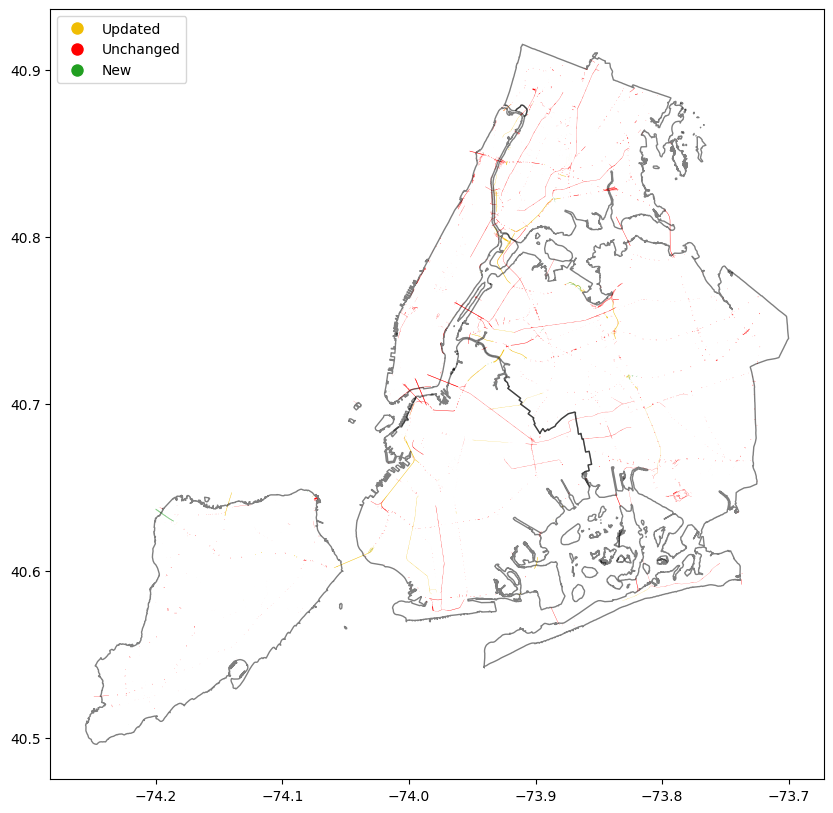

In [60]:
# Create a single figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot boundaries first (as background) - just outlines, no fill
boundaries.boundary.plot(ax=ax, color="black", linewidth=1, alpha=0.5)

# Plot transportation structures on top
transport.plot(ax=ax, color=transport["color"], legend=False)

# populate legend items based on dict from above
legend_colors = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

In [61]:
# It seems like there is a lot of missing data! Especially in Manhattan which is surprising.
# The map shows that the transportation structures are mostly unchanged, which is what I expected